In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randint

## Load Dataset

In [4]:
data= pd.read_csv("data.csv")
new_data = data.iloc[: , 1:]
labels = pd.read_csv("labels.csv")
new_label = labels.iloc[: , 1:]

In [5]:
X = new_data
y = new_label.values.ravel()

In [275]:
X.shape

(801, 20531)

In [276]:
y.shape

(801,)

## Feature Exraction - MutualInformation

In [6]:
from sklearn.feature_selection import mutual_info_classif as MIC

In [7]:
mi_score = MIC(X,y)

In [8]:
print("MI_score Details")
print("mean : ",np.mean(mi_score))
print("average : ",np.average(mi_score))
print("max_val : ",np.amax(mi_score))
print("min_val : ",np.amin(mi_score))

MI_score Details
mean :  0.17926091158937574
average :  0.17926091158937574
max_val :  0.9603974202960404
min_val :  0.0


In [9]:
reduced_features = np.where(mi_score > 0.5)[0]
reduced_features.shape

(474,)

In [10]:
X_MI = X.iloc[:,reduced_features]
X_MI.shape

(801, 474)

## FEATURE EXTRACTION - PrincipalComponentAnalysis (PCA)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.model_selection import train_test_split as tts

In [12]:
X_PCA = new_data
sc = StandardScaler()
X_PCA_std = sc.fit_transform(X_PCA)
pca = decomposition.PCA(n_components=0.95) #95% variance
X_PCA_applied = pca.fit_transform(X_PCA_std)
round(sum(list(pca.explained_variance_ratio_))*100, 2)

95.01

In [13]:
X_PCA_applied.shape

(801, 530)

$\;\;\;\;$

$\;\;\;\;$

In [209]:
# To suppress "ignore" warnings during tuning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


$\;\;\;\;$

$\;\;\;\;$

## DT MODEL(default)

In [16]:
from sklearn.tree import DecisionTreeClassifier as DTC

##### DT MODEL - Fature Extraction : MutualInformation

In [17]:
X_DTC_mi_train, X_DTC_mi_test, y_DTC_mi_train, y_DTC_mi_test = tts(X_MI,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
                                    

In [18]:
BaseModel_mi = DTC().fit(X_DTC_mi_train,y_DTC_mi_train)
score = BaseModel_mi.score(X_DTC_mi_test,y_DTC_mi_test)
print(score)

0.9751552795031055


##### DT MODEL - Fature Extraction : PrincipalComponentAnalysis

In [19]:
X_DTC_pca_train, X_DTC_pca_test, y_DTC_pca_train, y_DTC_pca_test = tts(X_PCA_applied,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)

In [20]:
BaseModel_pca = DTC().fit(X_DTC_pca_train,y_DTC_pca_train)
score = BaseModel_pca.score(X_DTC_pca_test,y_DTC_pca_test)
print(score)

0.8881987577639752


##### DT MODEL - Parameters : DTC_pca model

In [21]:
display(BaseModel_pca.get_params())
print("Number of leaves : ",BaseModel_pca.get_n_leaves())
print("Depth of DecisionTree : ",BaseModel_pca.get_depth())

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Number of leaves :  26
Depth of DecisionTree :  10


##### DT MODEL - Parameters : DTC_mi model

In [22]:
display(BaseModel_mi.get_params())
print("Number of leaves : ",BaseModel_mi.get_n_leaves())
print("Depth of DecisionTree : ",BaseModel_mi.get_depth())

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Number of leaves :  9
Depth of DecisionTree :  7


<b>FROM RUNNING COMPARISIONS BETWEEN "PCA" AND "MI" IT IS EVIDENT MI BASED FEATURE EXTRACTION IS BETER SUITED FOR THIS DATASET</b>

## TUNING DecisionTreeClassifier

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### PCA BASED (only for report/reference)

## Primary HyperParameter tuning - using RandomizedsearchCV

In [51]:
#Data
model4R_train,model4R_test,y4R_train,y4R_test = tts(X_PCA_applied,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

In [52]:
#Seed for reproducibility
seed(1)

#Parameters - RandomizedSearchCV
parameters4 = {"criterion":("gini","entropy"),
              "max_depth":(randint(1,10),randint(1,10),randint(1,10),randint(1,10),None),
              "min_samples_leaf":[int(x) for x in np.linspace(start = 1, stop = 50, num = 10)],
              "min_samples_split":[int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              "random_state":(randint(1,10),randint(1,10),randint(1,10),randint(1,10),None),
              "max_leaf_nodes":(randint(1,10),randint(11,30),randint(31,100),randint(101,200),None),
              "min_impurity_decrease":[float(x) for x in np.linspace(start = 0.0, stop = 0.9, num = 20)],
#               "ccp_alpha":[float(x) for x in np.linspace(start = 0.0, stop = 10.00, num = 30)],
              "splitter":("best","random"),
              "max_features":("auto","sqrt","log2",None),
              "class_weight":("balanced",None)
               }

In [65]:
#RandomizedSearchCV
dtc4R_cv = RandomizedSearchCV(estimator=DTC(),
                             param_distributions=parameters4,
                             n_jobs=-1,
                             n_iter=100,
                             random_state=2,
                             verbose=10)
dtc4R_cv.fit(model4R_train,y4R_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': ('balanced', None),
                                        'criterion': ('gini', 'entropy'),
                                        'max_depth': (6, 9, 6, 1, None),
                                        'max_features': ('auto', 'sqrt', 'log2',
                                                         None),
                                        'max_leaf_nodes': (3, 16, 49, 185,
                                                           None),
                                        'min_impurity_decrease': [0.0,
                                                                  0.04736842105263158,
                                                                  0.09473684210526316,
                                                                  0.1421052631578...
                                                                  0.473684210526315

In [66]:
#Best tune parameters
print("tuned hyperparameters RS_CV: ",dtc4R_cv.best_params_)
print("tuned highest score RS_CV: ",dtc4R_cv.best_score_)

tuned hyperparameters RS_CV:  {'splitter': 'best', 'random_state': 7, 'min_samples_split': 18, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 185, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': None}
tuned highest score RS_CV:  0.934375


In [382]:
#Results
results_RS = pd.DataFrame(dtc4R_cv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
results_RS = results_RS.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score',
           'split4_test_score',
           'std_test_score'
           ],
           axis=1)
results_RS

,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,mean_test_score,rank_test_score
0,best,7,18,6,0.0,185,None,None,entropy,None,0.934375,1
1,random,7,18,1,0.0,185,None,6,entropy,balanced,0.915625,2
2,best,7,44,17,0.142105,49,None,6,entropy,None,0.915625,2
3,best,8,12,50,0.236842,None,None,None,entropy,None,0.912500,4
4,best,1,18,44,0.142105,16,None,None,gini,balanced,0.745313,5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,best,7,34,33,0.568421,49,log2,9,entropy,balanced,0.110937,58
96,random,7,7,11,0.852632,185,log2,1,gini,balanced,0.110937,58
97,random,None,12,39,0.568421,3,auto,6,gini,balanced,0.110937,58
98,random,2,12,33,0.521053,16,sqrt,6,gini,balanced,0.110937,58


In [69]:
results_RS.head(10)

,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,mean_test_score,rank_test_score
0,best,7,18,6,0.0,185,None,None,entropy,None,0.934375,1
1,random,7,18,1,0.0,185,None,6,entropy,balanced,0.915625,2
2,best,7,44,17,0.142105,49,None,6,entropy,None,0.915625,2
3,best,8,12,50,0.236842,None,None,None,entropy,None,0.912500,4
4,best,1,18,44,0.142105,16,None,None,gini,balanced,0.745313,5
5,best,None,18,39,0.142105,185,None,6,gini,None,0.737500,6
6,random,2,28,50,0.094737,None,None,9,entropy,balanced,0.653125,7
7,best,1,34,6,0.426316,185,None,6,entropy,balanced,0.590625,8
8,best,1,7,33,0.521053,16,None,6,entropy,None,0.535937,9
9,best,1,50,33,0.047368,3,auto,None,entropy,None,0.535937,9


## Secondary HyperParameter tuning - using GridSearchCV
Obeservatios from the top 10 fields in Results of RandomizedSearchCV is used to analyze parameter range for GridSearchCV

In [70]:
#Data
X_val_train,X_val_test,y_val_train,y_val_test = tts(X_PCA_applied,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

In [71]:
#Parameters - GridSearchCV
param_grid = { "splitter": ("random","best"),
               "random_state": (1,7,8,None),
               "min_samples_split": (10,30,40,50),
               "min_samples_leaf": (1,10,20,50),
               "min_impurity_decrease": (0.0,0.10,0.20,0.40),
               "max_leaf_nodes": (10,50,100,200,None),
               "max_features": ("auto",None),
               "max_depth": (2,4,6,8,10,None),
               "criterion": ("gini","entropy"),
               "class_weight": ("balanced",None),
             }

In [74]:
modelGS = GridSearchCV(DTC(), param_grid, cv=3, verbose = 10, n_jobs=-1)

In [75]:
modelGS.fit(X_val_train, y_val_train)

Fitting 3 folds for each of 122880 candidates, totalling 368640 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ('balanced', None),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (2, 4, 6, 8, 10, None),
                         'max_features': ('auto', None),
                         'max_leaf_nodes': (10, 50, 100, 200, None),
                         'min_impurity_decrease': (0.0, 0.1, 0.2, 0.4),
                         'min_samples_leaf': (1, 10, 20, 50),
                         'min_samples_split': (10, 30, 40, 50),
                         'random_state': (1, 7, 8, None),
                         'splitter': ('random', 'best')},
             verbose=10)

In [76]:
#Best tuned parameters
print("tuned hyperparameters GS_CV: ",modelGS.best_params_)
print("tuned highest score GS_CV: ",modelGS.best_score_)

tuned hyperparameters GS_CV:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 30, 'random_state': None, 'splitter': 'best'}
tuned highest score GS_CV:  0.9421701548857006


In [77]:
#Results
results_GS = pd.DataFrame(modelGS.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
results_GS = results_GS.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
#            'split3_test_score',
#            'split4_test_score',
           'std_test_score'
           ],
           axis=1)
results_GS.head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_random_state,param_splitter,mean_test_score,rank_test_score
0,None,entropy,6,None,100,0.0,1,30,None,best,0.942170,1
1,None,entropy,6,None,10,0.0,1,10,1,best,0.940605,2
2,None,entropy,None,None,50,0.0,1,50,None,best,0.939048,3
3,None,entropy,10,None,10,0.0,1,10,1,best,0.939040,4
4,None,entropy,8,None,10,0.0,1,10,None,best,0.939040,4


In [81]:
BestModelDTC = DTC(min_samples_split=30,
                   min_samples_leaf=1,
                   max_features=None,
                   max_leaf_nodes=100,
                   min_impurity_decrease=0.0,
                   random_state=None,
                   splitter="best",
                   max_depth=6,
                   criterion="entropy",
                   class_weight=None
                  )
BestModelDTC.fit(X_val_train,y_val_train)
print("Tuned Best Test Result: ",
     BestModelDTC.score(X_val_test,y_val_test))

Tuned Best Test Result:  0.8757763975155279


In [82]:
BestModelDTC.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 100,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## EVALUATION (DTC model_pca (only for report/reference))

In [168]:
from sklearn.metrics import confusion_matrix, f1_score

In [84]:
#Evaluating Predictions
Eval_predict = BestModelDTC.predict(X_val_test)

In [85]:
new_label.value_counts()

Class
BRCA     300
KIRC     146
LUAD     141
PRAD     136
COAD      78
dtype: int64

In [177]:
#Confusion matrix - visual representation of Predictions
cnf_matrix = pd.DataFrame(confusion_matrix(y_val_test, Eval_predict), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])

In [178]:
display(cnf_matrix)

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,58,0,2,0,0
KIRC,0,15,0,1,0
LUAD,0,0,30,0,0
PRAD,1,0,0,27,0
COAD,1,0,0,0,26


In [88]:
display('Decision Tree f1 score', f1_score(y_val_test, Eval_predict,average='micro'))

'Decision Tree f1 score'

0.8757763975155279

### MI BASED (Actual Usuage)

## Primary HyperParameter tuning - using RandomizedSearchCV

In [89]:
#Data
X_RS_train,X_RS_test,y_RS_train,y_RS_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

In [90]:
#Seed for reproducibility
seed(1)

#Parameters - RandomizedSearchCV
RS_parameters = {"criterion":("gini","entropy"),
              "max_depth":(randint(1,10),randint(1,10),randint(1,10),randint(1,10),None),
              "min_samples_leaf":[int(x) for x in np.linspace(start = 1, stop = 50, num = 10)],
              "min_samples_split":[int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              "random_state":(randint(1,10),randint(1,10),randint(1,10),randint(1,10),None),
              "max_leaf_nodes":(randint(1,10),randint(11,30),randint(31,100),randint(101,200),None),
              "min_impurity_decrease":[float(x) for x in np.linspace(start = 0.0, stop = 0.9, num = 20)],
#               "ccp_alpha":[float(x) for x in np.linspace(start = 0.0, stop = 10.00, num = 30)],
              "splitter":("best","random"),
              "max_features":("auto","sqrt","log2",None),
              "class_weight":("balanced",None)
               }

In [94]:
#RandomizedSearchCV
RS_model = RandomizedSearchCV(estimator=DTC(),
                             param_distributions=RS_parameters,
                             n_jobs=-1,
                             n_iter=100,
                             random_state=2,
                             verbose=10)
RS_model.fit(X_RS_train,y_RS_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': ('balanced', None),
                                        'criterion': ('gini', 'entropy'),
                                        'max_depth': (6, 9, 6, 1, None),
                                        'max_features': ('auto', 'sqrt', 'log2',
                                                         None),
                                        'max_leaf_nodes': (3, 16, 49, 185,
                                                           None),
                                        'min_impurity_decrease': [0.0,
                                                                  0.04736842105263158,
                                                                  0.09473684210526316,
                                                                  0.1421052631578...
                                                                  0.473684210526315

In [95]:
#Best tuned Parameters
print("tuned hyperparameters RS_CV: ",RS_model.best_params_)
print("tuned highest score RS_CV: ",RS_model.best_score_)

tuned hyperparameters RS_CV:  {'splitter': 'best', 'random_state': 8, 'min_samples_split': 34, 'min_samples_leaf': 11, 'min_impurity_decrease': 0.18947368421052632, 'max_leaf_nodes': 16, 'max_features': None, 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced'}
tuned highest score RS_CV:  0.971875


In [378]:
#Results
RS_modelresults = pd.DataFrame(RS_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
RS_modelresults = RS_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score',
           'split4_test_score',
           'std_test_score'
           ],
           axis=1)
RS_modelresults

,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,mean_test_score,rank_test_score
0,best,8,34,11,0.189474,16,None,None,gini,balanced,0.971875,1
1,random,7,18,1,0.0,185,None,6,entropy,balanced,0.971875,1
2,best,1,18,44,0.142105,16,None,None,gini,balanced,0.970313,3
3,best,7,18,6,0.0,185,None,None,entropy,None,0.964063,4
4,best,7,44,17,0.142105,49,None,6,entropy,None,0.956250,5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,random,None,28,11,0.284211,185,auto,None,gini,balanced,0.110937,75
96,best,None,18,6,0.521053,185,None,6,gini,balanced,0.110937,75
97,random,8,34,33,0.284211,49,sqrt,9,gini,balanced,0.110937,75
98,best,8,39,33,0.805263,None,auto,9,entropy,balanced,0.110937,75


In [98]:
RS_modelresults.head(10)

,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,mean_test_score,rank_test_score
0,best,8,34,11,0.189474,16,None,None,gini,balanced,0.971875,1
1,random,7,18,1,0.0,185,None,6,entropy,balanced,0.971875,1
2,best,1,18,44,0.142105,16,None,None,gini,balanced,0.970313,3
3,best,7,18,6,0.0,185,None,None,entropy,None,0.964063,4
4,best,7,44,17,0.142105,49,None,6,entropy,None,0.956250,5
5,random,2,28,50,0.094737,None,None,9,entropy,balanced,0.951562,6
6,best,8,12,50,0.236842,None,None,None,entropy,None,0.937500,7
7,best,2,23,11,0.189474,16,auto,6,entropy,None,0.931250,8
8,best,8,34,28,0.0,49,log2,9,gini,balanced,0.928125,9
9,random,2,12,50,0.094737,49,auto,None,entropy,balanced,0.926562,10


## Secondary HyperParameter tuning - using GridSearchCV
Obeservatios from the top 10 fields in Results of RandomizedSearchCV is used to analyze parameter range for GridSearchCV

In [99]:
#Data
X_GS_train,X_GS_test,y_GS_train,y_GS_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

In [379]:
#Parameters - GridSearchCV
GS_parameters = { "splitter": ("random","best"),
               "random_state": (1,7,8,None),
               "min_samples_split": (10,30,40,50),
               "min_samples_leaf": (1,10,20,50),
               "min_impurity_decrease": (0.0,0.10,0.20,0.40),
               "max_leaf_nodes": (10,50,100,200,None),
               "max_features": ("auto",None),
               "max_depth": (2,4,6,8,10,None),
               "criterion": ("gini","entropy"),
               "class_weight": ("balanced",None),
             }

In [101]:
GS_model = GridSearchCV(DTC(), GS_parameters, cv=3, verbose = 10, n_jobs=-1)

In [102]:
GS_model.fit(X_GS_train, y_GS_train)

Fitting 3 folds for each of 122880 candidates, totalling 368640 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ('balanced', None),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (2, 4, 6, 8, 10, None),
                         'max_features': ('auto', None),
                         'max_leaf_nodes': (10, 50, 100, 200, None),
                         'min_impurity_decrease': (0.0, 0.1, 0.2, 0.4),
                         'min_samples_leaf': (1, 10, 20, 50),
                         'min_samples_split': (10, 30, 40, 50),
                         'random_state': (1, 7, 8, None),
                         'splitter': ('random', 'best')},
             verbose=10)

In [103]:
#Best tuned Parameters
print("tuned hyperparameters GS_CV: ",GS_model.best_params_)
print("tuned highest score GS_CV: ",GS_model.best_score_)

tuned hyperparameters GS_CV:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 30, 'random_state': None, 'splitter': 'random'}
tuned highest score GS_CV:  0.989060009067907


In [105]:
#Result
GS_modelresults = pd.DataFrame(GS_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
GS_modelresults = GS_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
#            'split3_test_score',
#            'split4_test_score',
           'std_test_score'
           ],
           axis=1)
GS_modelresults.head(5)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_random_state,param_splitter,mean_test_score,rank_test_score
0,balanced,gini,10,None,50,0.0,1,30,None,random,0.989060,1
1,balanced,gini,6,None,None,0.0,20,50,None,random,0.989045,2
2,balanced,entropy,10,None,100,0.0,1,30,None,random,0.987502,3
3,None,gini,None,None,200,0.0,10,30,None,random,0.987502,3
4,balanced,entropy,4,None,200,0.1,10,10,None,random,0.987495,5


In [380]:
#Fitting model to best parameters
BestModelDTC_mi = DTC(min_samples_split=30,
                   min_samples_leaf=1,
                   max_features=None,
                   max_leaf_nodes=50,
                   min_impurity_decrease=0.0,
                   random_state=None,
                   splitter="random",
                   max_depth=10,
                   criterion="gini",
                   class_weight="balanced"
                  )
BestModelDTC_mi.fit(X_GS_train,y_GS_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=50,
                       min_samples_split=30, splitter='random')

In [109]:
BestModelDTC_mi.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 50,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}

## EVALUATION (DTC model_mi)

In [358]:
Eval_predict_DTC = BestModelDTC_mi.predict(X_GS_test)
confusion_matrix_DTC = pd.DataFrame(confusion_matrix(y_GS_test, Eval_predict_DTC), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_DTC)
print('Decision Tree Classifier Model: f1 score -', f1_score(y_GS_test, Eval_predict_DTC,average='micro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,58,0,2,0,0
KIRC,0,15,0,1,0
LUAD,0,0,30,0,0
PRAD,1,0,0,27,0
COAD,1,0,0,0,26


Decision Tree Classifier Model: f1 score - 0.968944099378882


$\;\;\;\;$

$\;\;\;\;$

## RF MODEL(default)

In [111]:
from sklearn.ensemble import RandomForestClassifier

In [112]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

##### RF MODEL - Fature Extraction : MutualInformation

In [113]:
X_RF_mi_train, X_RF_mi_test, y_RF_mi_train, y_RF_mi_test = tts(X_MI,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
                                    

In [114]:
BaseModelRF_mi = rf.fit(X_RF_mi_train,y_RF_mi_train)
score = BaseModelRF_mi.score(X_RF_mi_test,y_RF_mi_test)
print(score)

0.9937888198757764


##### RF MODEL - Parameters : RF_mi

In [115]:
display(BaseModelRF_mi.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## TUNING RandomForestClassifier

## Primary HyperParameter tuning - using RandomizedSearchCV

In [116]:
#Data
X_RS2_train,X_RS2_test,y_RS2_train,y_RS2_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)
#Seed for reproducibility
seed(1)

#Parameters for RandomizedSearchCV
RS2_parameters = {"n_estimators":[int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)],
              "criterion": ("gini","entropy"),   
              "max_depth":(randint(2,10),randint(1,10),randint(1,10),randint(1,10),None),
              "min_samples_split":[int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              "min_samples_leaf":[int(x) for x in np.linspace(start = 1, stop = 50, num = 10)],
              "min_weight_fraction_leaf": [float(x) for x in np.linspace(start = 0.0, stop = 0.5, num = 5)],
              "max_features":("auto","sqrt","log2"),
              "max_leaf_nodes":(randint(2,10),randint(11,40),randint(41,90),randint(91,150),None),
              "min_impurity_decrease":[float(x) for x in np.linspace(start = 0.0, stop = 0.9, num = 20)],
              "bootstrap": [True, False],
              "class_weight":("balanced","balanced_subsample",None)
               }

#RandomizedSearchCV
RS2_model = RandomizedSearchCV(estimator=RandomForestClassifier(),
                             param_distributions=RS2_parameters,
                             n_jobs=-1,
                             n_iter=100,
                             random_state=2,
                             verbose=10)
RS2_model.fit(X_RS2_train,y_RS2_train)

#Results
RS2_modelresults = pd.DataFrame(RS2_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
RS2_modelresults = RS2_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score',
           'split4_test_score',
           'std_test_score'
           ],
           axis=1)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [117]:
RS2_modelresults.head(30)

,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_bootstrap,mean_test_score,rank_test_score
0,1400,0.125,18,17,0.094737,None,sqrt,None,gini,balanced,False,0.998437,1
1,900,0.125,34,17,0.094737,2,log2,None,gini,balanced,True,0.996875,2
2,400,0.125,50,28,0.142105,2,auto,7,gini,balanced,True,0.996875,2
3,100,0.0,18,17,0.142105,12,auto,9,gini,balanced_subsample,True,0.996875,2
4,900,0.125,28,6,0.426316,53,sqrt,6,entropy,balanced,True,0.995313,5
5,1600,0.0,34,11,0.284211,None,auto,7,entropy,balanced,True,0.995313,5
6,300,0.125,28,28,0.378947,53,auto,7,entropy,balanced_subsample,True,0.995313,5
7,800,0.0,7,17,0.047368,None,log2,6,entropy,balanced,True,0.995313,5
8,1700,0.125,12,44,0.236842,None,log2,9,entropy,None,False,0.995313,5
9,100,0.125,23,44,0.284211,53,auto,None,entropy,balanced_subsample,False,0.993750,10


In [118]:
#Best tuned Parameters
print("tuned hyperparameters RS_CV: ",RS2_model.best_params_)
print("tuned highest score RS_CV: ",RS2_model.best_score_)

tuned hyperparameters RS_CV:  {'n_estimators': 1400, 'min_weight_fraction_leaf': 0.125, 'min_samples_split': 18, 'min_samples_leaf': 17, 'min_impurity_decrease': 0.09473684210526316, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}
tuned highest score RS_CV:  0.9984375


## Secondary HyperParameter tuning - using GridSearchCV
Obeservatios from the top 30 fields in Results of RandomizedSearchCV is used to analyze parameter range for GridSearchCV

In [123]:
#Data
X_GS2_train,X_GS2_test,y_GS2_train,y_GS2_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

In [134]:
#Parameters for GridSearchCV
GS2_parameters = {
              "n_estimators":(100,400,1000),
              "criterion": ("gini","entropy"),   
              "max_depth":(1,7,9,None),
#               "min_samples_split":(10,30,50),
#               "min_samples_leaf":(10,30,50),
#               "min_weight_fraction_leaf": (0.0,0.20,0.40),
              "max_features":("auto","sqrt","log2"),
              "max_leaf_nodes":(2,10,50,None),
#               "min_impurity_decrease":(0.0,0.10,0.40),
              "bootstrap": [True, False],
              "class_weight":("balanced","balanced_subsample",None)
             }


In [135]:
#GridSearchCV
GS2_model = GridSearchCV(RandomForestClassifier(), GS2_parameters, cv=3, verbose = 10, n_jobs=-1)
GS2_model.fit(X_GS2_train, y_GS2_train)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ('balanced', 'balanced_subsample',
                                          None),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (1, 7, 9, None),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'max_leaf_nodes': (2, 10, 50, None),
                         'n_estimators': (100, 400, 1000)},
             verbose=10)

In [136]:
#Results
GS2_modelresults = pd.DataFrame(GS2_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
GS2_modelresults = GS2_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
#            'split3_test_score',
#            'split4_test_score',
           'std_test_score'
           ],
           axis=1)


In [137]:
GS2_modelresults.head(5)

,param_bootstrap,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_n_estimators,mean_test_score,rank_test_score
0,True,balanced,gini,1,auto,50,400,1.000000,1
1,True,None,gini,7,log2,50,100,0.998435,2
2,False,None,gini,9,sqrt,None,1000,0.998435,2
3,False,None,gini,9,sqrt,None,400,0.998435,2
4,False,None,gini,9,sqrt,None,100,0.998435,2


In [138]:
#Best tuned parameters
print("tuned hyperparameters GS_CV: ",GS2_model.best_params_)
print("tuned highest score GS_CV: ",GS2_model.best_score_)


tuned hyperparameters GS_CV:  {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': 50, 'n_estimators': 400}
tuned highest score GS_CV:  1.0


In [140]:
#Best tuned Model selection & scoring
BestModelRF_mi = RandomForestClassifier(bootstrap=True,
                   class_weight="balanced",
                   criterion="gini",
                   max_depth=1,
                   max_features="auto",
                   max_leaf_nodes=50,
                   n_estimators=400
                  )
BestModelRF_mi.fit(X_GS2_train,y_GS2_train)
print("Tuned Best Test Result: ",
     BestModelRF_mi.score(X_GS2_test,y_GS2_test))

Tuned Best Test Result:  0.9937888198757764


In [141]:
#Best tuned Model parameters
BestModelRF_mi.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## EVALUATION (RF model_mi)

In [357]:
Eval_predict_RF = BestModelRF_mi.predict(X_GS2_test)
confusion_matrix_RF = pd.DataFrame(confusion_matrix(y_GS2_test, Eval_predict_RF), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_RF)
print('Random Forest Classifier Model: f1 score -', f1_score(y_GS2_test, Eval_predict_RF,average='macro'))


,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,30,0,0
PRAD,1,0,0,27,0
COAD,0,0,0,0,27


Random Forest Classifier Model: f1 score - 0.994710743801653


$\;\;\;\;$

$\;\;\;\;$

## KNN MODEL(default)

In [185]:
from sklearn.neighbors import KNeighborsClassifier

In [186]:
knn = KNeighborsClassifier()

##### KNN MODEL - Fature Extraction : MutualInformation

In [187]:
X_KNN_mi_train, X_KNN_mi_test, y_KNN_mi_train, y_KNN_mi_test = tts(X_MI,y,
                                                                   test_size=0.20,
                                                                   random_state=42,
                                                                   stratify=y)
                                    
BaseModelKNN_mi = knn.fit(X_KNN_mi_train,y_KNN_mi_train)
score = BaseModelKNN_mi.score(X_KNN_mi_test,y_KNN_mi_test)
print(score)

0.9937888198757764


##### KNN MODEL - Parameters : KNN_mi

In [188]:
display(BaseModelKNN_mi.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

## TUNING KNNClassifier

## Primary HyperParameter tuning - using RandomizedSearchCV

In [210]:
#Data
X_RS3_train,X_RS3_test,y_RS3_train,y_RS3_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

#Normalising data for better results
X_scaled_RS3_train = sc.fit_transform(X_RS3_train)
X_scaled_RS3_test = sc.fit_transform(X_RS3_test)

#Seed for reproducibility
seed(1)

#Parameters for RandomizedSearchCV
RS3_parameters = {"n_neighbors":[int(x) for x in np.linspace(start = 1, stop = 200, num = 1)],
              "weights":("uniform","distance"),
              "algorithm":("auto","ball_tree","kd_tree","brute"),
              "leaf_size":[int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
              "p":[int(x) for x in np.linspace(start = 1, stop = 10, num = 1)],
              "metric":("euclidean","manhattan","minkowski","seuclidean")
               }

#RandomizedSearchCV
RS3_model = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                             param_distributions=RS3_parameters,
                             n_jobs=-1,
                             n_iter=100,
                             random_state=2,
                             verbose=10)
RS3_model.fit(X_scaled_RS3_train,y_RS3_train)

#Results
RS3_modelresults = pd.DataFrame(RS3_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
RS3_modelresults = RS3_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score',
           'split4_test_score',
           'std_test_score'
           ],
           axis=1)




Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [194]:
RS3_modelresults.head(10)

,param_weights,param_p,param_n_neighbors,param_metric,param_leaf_size,param_algorithm,mean_test_score,rank_test_score
0,uniform,1,1,manhattan,89,auto,0.996875,1
1,distance,1,1,manhattan,100,ball_tree,0.996875,1
2,distance,1,1,euclidean,100,brute,0.996875,1
3,uniform,1,1,manhattan,23,brute,0.996875,1
4,uniform,1,1,manhattan,23,kd_tree,0.996875,1
5,uniform,1,1,manhattan,1,auto,0.996875,1
6,uniform,1,1,minkowski,12,kd_tree,0.996875,1
7,distance,1,1,manhattan,12,ball_tree,0.996875,1
8,uniform,1,1,euclidean,100,ball_tree,0.996875,1
9,uniform,1,1,manhattan,89,kd_tree,0.996875,1


In [195]:
#Best tuned Parameters
print("tuned hyperparameters RS_CV: ",RS3_model.best_params_)
print("tuned highest score RS_CV: ",RS3_model.best_score_)

tuned hyperparameters RS_CV:  {'weights': 'distance', 'p': 1, 'n_neighbors': 1, 'metric': 'seuclidean', 'leaf_size': 1, 'algorithm': 'auto'}
tuned highest score RS_CV:  0.996875


## Secondary HyperParameter tuning - using GridSearchCV
Obeservatios from the top 10 fields in Results of RandomizedSearchCV is used to analyze parameter range for GridSearchCV

In [197]:
#Data
X_GS3_train,X_GS3_test,y_GS3_train,y_GS3_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

In [198]:
#Normalising data for better results
X_scaled_GS3_train = sc.fit_transform(X_GS3_train)
X_scaled_GS3_test = sc.fit_transform(X_GS3_test)

In [200]:
#Parameters for GridSearchCV
GS3_parameters = { "n_neighbors":[int(x) for x in np.linspace(start = 1, stop = 200, num = 1)],
              "weights":("uniform","distance"),
              "algorithm":("auto","ball_tree","kd_tree","brute"),
              "leaf_size":[int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
              "p":[int(x) for x in np.linspace(start = 1, stop = 10, num = 1)],
              "metric":("euclidean","manhattan","minkowski","seuclidean")
             }


In [211]:
#GridSearchCV
GS3_model = GridSearchCV(KNeighborsClassifier(), GS3_parameters, cv=3, verbose = 10, n_jobs=-1)
GS3_model.fit(X_scaled_GS3_train, y_GS3_train)


Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'leaf_size': [1, 12, 23, 34, 45, 56, 67, 78, 89, 100],
                         'metric': ('euclidean', 'manhattan', 'minkowski',
                                    'seuclidean'),
                         'n_neighbors': [1], 'p': [1],
                         'weights': ('uniform', 'distance')},
             verbose=10)

In [212]:
#Results
GS3_modelresults = pd.DataFrame(GS3_model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
GS3_modelresults = GS3_modelresults.drop([
           'mean_fit_time', 
           'std_fit_time', 
           'mean_score_time',
           'std_score_time', 
           'params', 
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
#            'split3_test_score',
#            'split4_test_score',
           'std_test_score'
           ],
           axis=1)


In [213]:
GS3_modelresults.head(5)

,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,mean_test_score,rank_test_score
0,auto,1,euclidean,1,1,uniform,0.99687,1
1,kd_tree,78,euclidean,1,1,distance,0.99687,1
2,kd_tree,78,euclidean,1,1,uniform,0.99687,1
3,kd_tree,67,minkowski,1,1,distance,0.99687,1
4,kd_tree,67,minkowski,1,1,uniform,0.99687,1


In [205]:
#Best tuned parameters
print("tuned hyperparameters GS_CV: ",GS3_model.best_params_)
print("tuned highest score GS_CV: ",GS3_model.best_score_)

tuned hyperparameters GS_CV:  {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
tuned highest score GS_CV:  0.996870109546166


In [214]:
#Best tuned Model selection & scoring
BestModelKNN_mi = KNeighborsClassifier(algorithm="auto",
                   leaf_size=1,
                   metric="euclidean",
                   n_neighbors=1,
                   p=1,
                   weights="uniform"
                  )
BestModelKNN_mi.fit(X_scaled_GS3_train,y_GS3_train)
print("Tuned Best Test Result: ",
     BestModelKNN_mi.score(X_scaled_GS3_test,y_GS3_test))

Tuned Best Test Result:  0.9937888198757764


In [215]:
#Best tuned Model parameters
BestModelKNN_mi.get_params()

{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 1,
 'weights': 'uniform'}

## EVALUATION (KNN model_mi)

In [356]:
Eval_predict_KNN = BestModelKNN_mi.predict(X_scaled_GS3_test)
confusion_matrix_KNN = pd.DataFrame(confusion_matrix(y_GS3_test, Eval_predict_KNN), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_KNN)
print('KNN Classifier Model: f1 score -', f1_score(y_GS3_test, Eval_predict_KNN,average='macro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,30,0,0
PRAD,1,0,0,27,0
COAD,0,0,0,0,27


KNN Classifier Model: f1 score - 0.994710743801653


$\;\;\;\;$

$\;\;\;\;$

$\;\;\;\;$

## FINALISED MODEL 
After comparing DecisionTreeClassifier and RandomeForrestClassifier (the two selected classifiers for this classification task) with KNeighborsClassifier, it can be concluded based on "F1-score" that - Random Forest Classifier is the best model for this dataset

###### WITHOUT CROSS VALIDATION

In [352]:
#Data
X_train,X_test,y_train,y_test = tts(X_MI,y, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y)

In [353]:
#Selected classifier for Gene_Task
SelectedModel = RandomForestClassifier(bootstrap=True,
                   class_weight="balanced",
                   criterion="gini",
                   max_depth=1,
                   max_features="auto",
                   max_leaf_nodes=50,
                   n_estimators=400
                  )
SelectedModel.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=1, max_leaf_nodes=50,
                       n_estimators=400)

In [354]:
#Best tuned Model parameters
SelectedModel.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [355]:
#Evaluating model performance
Eval_predict = SelectedModel.predict(X_test)
confusion_matrix_model = pd.DataFrame(confusion_matrix(y_test, Eval_predict), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_model)
print('Random Forest Classifier Model: f1 score -', f1_score(y_test, Eval_predict,average='macro'))


,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,30,0,0
PRAD,2,0,0,26,0
COAD,0,0,0,0,27


Random Forest Classifier Model: f1 score - 0.9893139040680025


###### USING CROSS VALIDATION

## KFold

In [234]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
X_validation = X_MI
y_validation = new_label
i_fold = [3, 5, 7]
for n in i_fold:
    cv = KFold(n_splits=n, random_state=1, shuffle=True)
    model = SelectedModel
    scores = cross_val_score(model, X_validation, y_validation, scoring='f1_macro', cv=cv, n_jobs=-1)
    print(' Fold: %d ; f1-score: %.3f' % (n, mean(scores)))
    
     

 Fold: 3 ; Accuracy: 0.998
 Fold: 5 ; Accuracy: 0.995
 Fold: 7 ; Accuracy: 0.992


## Leave-One-Out

In [238]:
from sklearn.model_selection import LeaveOneOut
cv2 = LeaveOneOut()
model2 = SelectedModel
scores2 = cross_val_score(model2, X_validation, y_validation, scoring='f1_macro', cv=cv2, n_jobs=-1)
print('f1-score: %.3f' % (mean(scores2)))


f1-score: 0.995


$\;\;\;\;$

$\;\;\;\;$

$\;\;\;\;$

## Data Augmentation

#### Using SMOTE - to address class imbalance 

In [241]:
!pip install imblearn

     |████████████████████████████████| 189 kB 3.9 MB/s            


In [251]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

AUGMENTED DATASET-1

In [359]:
#Augmenting dataset using SMOTE
X_reshaped,y_reshaped = SMOTE().fit_resample(new_data,new_label)

In [360]:
X_reshaped.shape

(1500, 20531)

In [361]:
y_reshaped.shape

(1500, 1)

In [362]:
y_reshaped.value_counts()

Class
BRCA     300
COAD     300
KIRC     300
LUAD     300
PRAD     300
dtype: int64

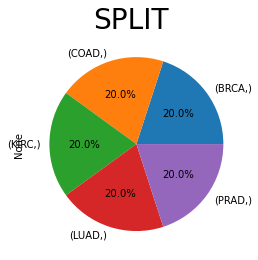

In [363]:
y_reshaped.value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.suptitle('SPLIT', size=28)
plt.show()

AUGMENTED DATASET-2

In [364]:
#Augmenting dataset using BorderlineSMOTE
X_reshaped2,y_reshaped2 = BorderlineSMOTE().fit_resample(new_data,new_label)

In [365]:
X_reshaped2.shape

(955, 20531)

In [366]:
y_reshaped2.shape

(955, 1)

In [367]:
y_reshaped2.value_counts()

Class
BRCA     300
KIRC     300
LUAD     141
PRAD     136
COAD      78
dtype: int64

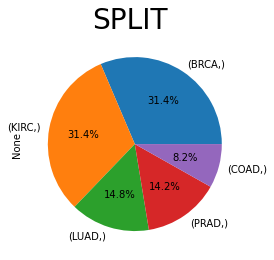

In [368]:
y_reshaped2.value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.suptitle('SPLIT', size=28)
plt.show()

#### MODEL PERFORMANCE WITH DATASET-1

In [369]:
#Restructing label data
y_changed = y_reshaped.values.ravel()

In [370]:
#Data
X_augmented_train,X_augmented_test,y_augmented_train,y_augmented_test = tts(X_reshaped,y_changed, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y_changed)



In [371]:
#Model fitted on training data
SelectedModel.fit(X_augmented_train,y_augmented_train)

RandomForestClassifier(class_weight='balanced', max_depth=1, max_leaf_nodes=50,
                       n_estimators=400)

In [372]:
#Evaluating performace of model on augmented Dataset1
Eval_predict_DS1 = SelectedModel.predict(X_augmented_test)
confusion_matrix_model_DS1 = pd.DataFrame(confusion_matrix(y_augmented_test, Eval_predict_DS1), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_model_DS1)
print('Random Forest Classifier Model on Augmented Dataset-1: f1 score -', f1_score(y_augmented_test, Eval_predict_DS1,average='macro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,60,0,0,0
LUAD,0,0,60,0,0
PRAD,0,0,0,60,0
COAD,0,0,0,0,60


Random Forest Classifier Model on Augmented Dataset-1: f1 score - 1.0


#### MODEL PERFORMANCE WITH DATASET-1

In [373]:
#Restructing label data
y_changed2 = y_reshaped2.values.ravel()

In [374]:
#Data
X_augmented2_train,X_augmented2_test,y_augmented2_train,y_augmented2_test = tts(X_reshaped2,y_changed2, 
                                    test_size=0.20,
                                    random_state=42,
                                    stratify=y_changed2)



In [375]:
#Model fitted on training data
SelectedModel.fit(X_augmented2_train,y_augmented2_train)

RandomForestClassifier(class_weight='balanced', max_depth=1, max_leaf_nodes=50,
                       n_estimators=400)

In [376]:
#Evaluating performace of model on augmented Dataset2
Eval_predict_DS2 = SelectedModel.predict(X_augmented2_test)
confusion_matrix_model_DS2 = pd.DataFrame(confusion_matrix(y_augmented2_test, Eval_predict_DS2), 
                                     index = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'], 
                                     columns = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD'])
display(confusion_matrix_model_DS2)
print('Random Forest Classifier Model on Augmented Dataset-1: f1 score -', f1_score(y_augmented2_test, Eval_predict_DS2,average='macro'))

,BRCA,KIRC,LUAD,PRAD,COAD
BRCA,60,0,0,0,0
KIRC,0,16,0,0,0
LUAD,0,0,60,0,0
PRAD,0,1,0,27,0
COAD,0,0,0,0,27


Random Forest Classifier Model on Augmented Dataset-1: f1 score - 0.9903030303030302


$\;\;\;\;$

$\;\;\;\;$

$\;\;\;\;$

$\;\;\;\;$

## ENSEMBLE?

BAGGING

In [ ]:
from sklearn.ensemble import StackingClassifier

In [385]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier

In [459]:
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

In [460]:
model = BaggingClassifier(base_estimator=DTC(min_samples_split=30,
                   min_samples_leaf=1,
                   max_features=None,
                   max_leaf_nodes=50,
                   min_impurity_decrease=0.0,
                   random_state=None,
                   splitter="random",
                   max_depth=10,
                   criterion="gini",
                   class_weight="balanced"), n_estimators=100, random_state=42)

In [461]:
results = model_selection.cross_val_score(model, X_MI,y, cv=kfold)

In [462]:
print(results.mean())

0.9975000000000002


$\;\;\;\;$

##BOOSTING

In [412]:
# from sklearn.ensemble import AdaBoostClassifier
# kfold2 = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
# model2 = AdaBoostClassifier(n_estimators=50, random_state=seed)
# results2 = model_selection.cross_val_score(model2, X_MI,y, cv=kfold2)
# print(results2.mean())

$\;\;\;\;$

VOTING BASED

In [419]:
from sklearn.ensemble import VotingClassifier

In [440]:
estimators = []

In [441]:
model_1 = DTC(min_samples_split=30,
                   min_samples_leaf=1,
                   max_features=None,
                   max_leaf_nodes=50,
                   min_impurity_decrease=0.0,
                   random_state=None,
                   splitter="random",
                   max_depth=10,
                   criterion="gini",
                   class_weight="balanced"
                  )

In [442]:
estimators.append(('Decision Tree', model_1))

In [443]:
model_2 = RandomForestClassifier(bootstrap=True,
                   class_weight="balanced",
                   criterion="gini",
                   max_depth=1,
                   max_features="auto",
                   max_leaf_nodes=50,
                   n_estimators=400
                  )

In [444]:
estimators.append(('Random Forest', model_2))

In [445]:
model_3 = KNeighborsClassifier(algorithm="auto",
                   leaf_size=1,
                   metric="euclidean",
                   n_neighbors=1,
                   p=1,
                   weights="uniform"
                  )

In [446]:
estimators.append(('KNN', model_3))

In [447]:
ensemble = VotingClassifier(estimators)

In [463]:
results3 = model_selection.cross_val_score(ensemble, X_MI,y, cv=kfold)

In [464]:
print(results3.mean())

0.9962500000000001


$\;\;\;\;$

$\;\;\;\;$